In [1]:
import os ,sys 
import pandas as pd 
import matplotlib.pyplot as plt
import numpy as np 
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
import tensorflow as tf
from tensorflow import keras
from tensorflow.keras import layers

/Users/barradd/anaconda2/lib/python2.7/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters


In [2]:
np.random.seed(101)

In [3]:
print (tf.__version__)

1.9.0


In [4]:
df = pd.read_csv('SubCh1_TrainingData.csv')

In [5]:
df.set_index("Sample_Name",inplace=True)

In [6]:
df_edit = pd.concat( [df, pd.get_dummies(df["Treatment"]),pd.get_dummies( df["Timepoint"])]
                         ,axis=1,sort=True )

In [7]:
df = df_edit.drop(["Treatment","Timepoint","BioRep","Isolate"],axis=1)

In [8]:
y = df["DHA_IC50"]
X = df.drop("DHA_IC50",axis=1)

In [9]:
# for m in df.columns:
#     print (m,df[df[m].isna()].shape[0])
sc = StandardScaler()

In [10]:
Xsc = sc.fit_transform(X)

/Users/barradd/anaconda2/lib/python2.7/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/Users/barradd/anaconda2/lib/python2.7/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [11]:
X_train, X_test, y_train, y_test = train_test_split(Xsc, y,
                                                    test_size=0.3,
                                                    random_state=42)

In [12]:
X_train.shape[1]

5544

In [13]:
def build_model():
    model = keras.Sequential([
    layers.Dense(640, activation=tf.nn.relu, input_shape=[X_train.shape[1]]),
    layers.Dense(640, activation=tf.nn.relu),
        layers.Dense(640, activation=tf.nn.relu),
        layers.Dense(640, activation=tf.nn.relu),
        layers.Dense(640, activation=tf.nn.relu),
   # layers.Dense(64, activation=tf.nn.relu),
    #layers.Dense(64, activation=tf.nn.relu),
#         layers.Dense(128, activation=tf.nn.relu),
#         layers.Dense(128, activation=tf.nn.relu),
#         layers.Dense(128, activation=tf.nn.relu),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(64, activation=tf.nn.relu),
    layers.Dense(1)
  ])

    optimizer = tf.keras.optimizers.RMSprop(0.001)

    model.compile(loss='mean_squared_error',
                optimizer=optimizer,
                metrics=['mean_absolute_error', 'mean_squared_error'])
    return model

In [14]:
model = build_model()
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense (Dense)                (None, 640)               3548800   
_________________________________________________________________
dense_1 (Dense)              (None, 640)               410240    
_________________________________________________________________
dense_2 (Dense)              (None, 640)               410240    
_________________________________________________________________
dense_3 (Dense)              (None, 640)               410240    
_________________________________________________________________
dense_4 (Dense)              (None, 640)               410240    
_________________________________________________________________
dense_5 (Dense)              (None, 64)                41024     
_________________________________________________________________
dense_6 (Dense)              (None, 64)                4160      
__________

In [15]:
# Display training progress by printing a single dot for each completed epoch
class PrintDot(keras.callbacks.Callback):
    def on_epoch_end(self, epoch, logs):
        if epoch % 100 == 0: 
            print('.')
            #print('.', end='')

EPOCHS = 1000

# history = model.fit(
#   X_train, y_train,
#   epochs=EPOCHS, validation_split = 0.2, verbose=0,
#   callbacks=[PrintDot()])

In [16]:
# hist = pd.DataFrame(history.history)
# hist['epoch'] = history.epoch
# hist.tail()

In [17]:
def plot_history(history):
    
    hist = pd.DataFrame(history.history)
    hist['epoch'] = history.epoch

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Abs Error [MPG]')
    plt.plot(hist['epoch'], hist['mean_absolute_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_absolute_error'],
           label = 'Val Error')
    plt.ylim([0,5])
    plt.legend()

    plt.figure()
    plt.xlabel('Epoch')
    plt.ylabel('Mean Square Error [$MPG^2$]')
    plt.plot(hist['epoch'], hist['mean_squared_error'],
           label='Train Error')
    plt.plot(hist['epoch'], hist['val_mean_squared_error'],
           label = 'Val Error')
    plt.ylim([0,20])
    plt.legend()
    plt.show()


#plot_history(history)

.


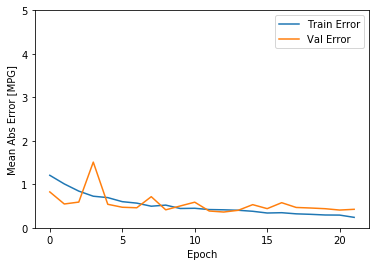

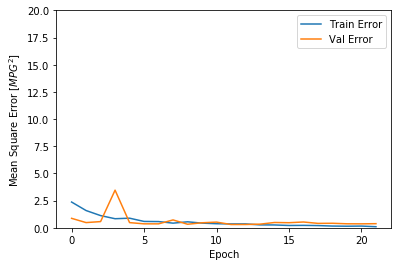

In [18]:
model = build_model()

# The patience parameter is the amount of epochs to check for improvement
early_stop = keras.callbacks.EarlyStopping(monitor='val_loss', patience=10)

history = model.fit(X_train, y_train, epochs=1000,batch_size=2,
                    validation_split = 0.2, verbose=0, callbacks=[early_stop, PrintDot()])

plot_history(history)

In [19]:
loss, mae, mse = model.evaluate(X_test, y_test, verbose=0)

print("Testing set Mean Abs Error: {:5.2f} MAE".format(mae))

Testing set Mean Abs Error:  0.41 MPG


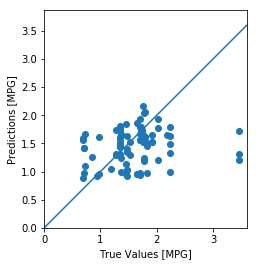

In [20]:
test_predictions = model.predict(X_test).flatten()

plt.scatter(y_test, test_predictions)
plt.xlabel('True Values [MAE]')
plt.ylabel('Predictions [MAE]')
plt.axis('equal')
plt.axis('square')
plt.xlim([0,plt.xlim()[1]])
plt.ylim([0,plt.ylim()[1]])
_ = plt.plot([-100, 100], [-100, 100])
plt.show()


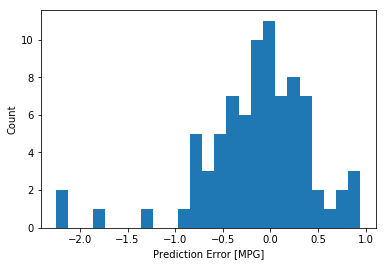

In [21]:
error = test_predictions - y_test
plt.hist(error, bins = 25)
plt.xlabel("Prediction Error [MAE]")
_ = plt.ylabel("Count")
plt.show()

In [22]:
from sklearn.metrics import mean_absolute_error,mean_squared_error,r2_score

In [23]:
print ("R^2:",r2_score(y_test, test_predictions))
print ("MAE:",mean_absolute_error(y_test, test_predictions))
print ("MSE:",mean_squared_error(y_test, test_predictions))

('R^2:', -0.20312481255943093)
('MAE:', 0.4143289913770628)
('MSE:', 0.34895147186993725)


In [24]:
def evaluate(model, test_features, test_labels):
    predictions = model.predict(test_features).flatten()
    errors = abs(predictions - test_labels)
    mape = 100 * np.mean(errors / test_labels)
    accuracy = 100 - mape
    print('Model Performance')
    print('Average Error: {:0.4f} degrees.'.format(np.mean(errors)))
    print('Accuracy = {:0.2f}%.'.format(accuracy))
    
    return accuracy

In [25]:
base_accuracy = evaluate(model, X_test, y_test)

Model Performance
Average Error: 0.4143 degrees.
Accuracy = 72.20%.
